# Обучение логистической регрессии, случайного леса и градиентного бустинга

## 1 Импорт библиотек, инициализация глобальных констант

### 1.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from colorama import Fore, Back, Style

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split

### 1.2 Инициализация констант

In [2]:
# путь к папке с данными
path = Path('C:/Users/alexander/imputed_data')
# название целевой переменной
TARGET_NAME = 'Approved'
# количество фолдов для кросс-валидации
N_FOLDS = 5
# random state для воспроизводимости
RANDOM_STATE = 42
# размер отложенной выборки
TEST_SIZE = 0.2

## 2 Подготовка данных

In [3]:
train = pd.read_csv(path / 'train_imputed.csv')
test = pd.read_csv(path / 'test_imputed.csv')
train

,ID,Gender,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,...,Credit_over_income,Credit_pct_over_income,Monthly_Income_in_city,Monthly_Income_at_employer,Monthly_Income_in_source_category,Monthly_Income_over_city_income,Monthly_Income_over_employeer_income,Monthly_Income_over_category_income,Loan_Amount_is_null,Age
0,APPC90493171225,Female,C10001,A,another,A,4.0,2000.0,B001,P,...,0.000000,0.000000,13461.737114,2000.000000,4517.348356,0.148569,1.000000,0.442738,1,36
1,APPD40611263344,Male,C10003,A,COM0000002,C,1.0,3500.0,B002,P,...,2.857143,0.378571,4130.332287,4789.257987,4517.348356,0.847389,0.730802,0.774791,0,29
2,APPE70289249423,Male,another,C,another,C,4.0,2250.0,B003,G,...,5.000000,0.000000,3668.495833,2250.000000,6218.750490,0.613330,1.000000,0.361809,0,33
3,APPF80273865537,Male,another,C,another,A,4.0,3500.0,B003,G,...,5.257143,0.000000,1525.000000,2700.000000,6218.750490,2.295082,1.296296,0.562814,0,27
4,APPG60994436641,Male,C10002,A,another,A,4.0,10000.0,B001,P,...,2.500000,0.000000,4465.358272,6644.750000,6218.750490,2.239462,1.504948,1.608040,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69708,APPU90955789628,Female,C10006,A,COM0000010,A,1.0,4900.0,B002,P,...,0.000000,0.000000,4042.877278,5781.724828,4517.348356,1.212008,0.847498,1.084707,1,33
69709,APPV80989824738,Female,another,C,another,A,4.0,7190.1,B002,P,...,0.000000,0.000000,4886.480000,7190.100000,4517.348356,1.471427,1.000000,1.591664,1,45
69710,APPW50697209842,Female,C10022,B,another,C,4.0,1600.0,B030,P,...,3.750000,1.331250,3472.887186,1625.000000,4517.348356,0.460712,0.984615,0.354190,0,24
69711,APPY50870035036,Male,C10002,A,another,C,3.0,9893.0,B002,P,...,1.617305,0.000000,4465.358272,3265.884615,4517.348356,2.215500,3.029195,2.190002,0,38


### 2.1 Используемые признаки при обучении

In [4]:
# используемые признаки при обучении
features = [
    c for c in train.columns if c != 'ID' and c != 'Approved'
    and c != 'Monthly_Income_in_source_category'
]
# численные признаки
num_features = train.select_dtypes(
    include=[int, float]).nunique()[lambda x: x > 25].index
# категориальные признаки
cat_features = list(set(features) - set(num_features))
# признаки, имеющие тяжелые хвосты распределения
to_log = [
    'Monthly_Income', 'Existing_EMI', 'Loan_Amount', 'EMI',
    'Loan_Amount_per_Period', 'Credit_pct', 'Credit_pct_per_Period',
    'Amount_plus_pct', 'Amount_plus_pct_per_period',
    'Amount_plus_pct_over_amount', 'Credit_over_income',
    'Monthly_Income_in_city', 'Monthly_Income_at_employer',
    'Monthly_Income_over_city_income', 'Monthly_Income_over_employeer_income',
    'Monthly_Income_over_category_income'
]

In [5]:
# прологарифмируем выбранные признаки
for col in to_log:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])

### 2.2 Отложенная выборка

In [6]:
tr_data, te_data = train_test_split(train,
                                    test_size=TEST_SIZE,
                                    random_state=RANDOM_STATE,
                                    stratify=train[TARGET_NAME])
tr_data = tr_data.reset_index(drop=True)
target = te_data[TARGET_NAME]

## 3 Вспомогательные функции

### 3.1 Функция для обучения модели и получения предсказания на тестовой выборке

In [7]:
def get_model_predictions(train, test, model, transfromer=None, verbose=True):
    """
    Функция для обучения модели и получения предсказаний.
    
    Параметры
    ----------
    train - обучающая выборка
    test - тестовая выборка
    model - модель
    transfromer - column_transformer для предобработки данных
    verbose - нужно ли выводить результаты на каждом фолде
    
    Возвращает
    -------
    test_preds - предсказания на тестовой выборке
    score_list - roc-auc на кросс-валидации для каждого фолда
    """
    score_list = []
    test_preds = np.zeros(len(test))
    target = train.loc[:, TARGET_NAME].values

    if transfromer:
        train = transfromer.fit_transform(train[features])
        test = transfromer.transform(test[features])
    else:
        train = train[features].values
        test = test[features].values

    kf = StratifiedKFold(n_splits=N_FOLDS,
                         shuffle=True,
                         random_state=RANDOM_STATE)
    for fold, (train_index, val_index) in enumerate(kf.split(train, target)):
        X_train = train[train_index]
        X_val = train[val_index]
        y_train = target[train_index]
        y_val = target[val_index]

        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, preds)
        test_preds += model.predict_proba(test)[:, 1] / kf.n_splits

        if verbose:
            print(f"FOLD: {fold}, ROC-AUC: {score:.5f}")
        score_list.append(score)

    return test_preds, score_list

### 3.2 Предобработка данных

Для линейной регрессии кодируем категориальные признаки с помощью OneHotEncoder, числовые масштабируем с помощью StandardScaler

In [8]:
column_transformer_lr = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False,
                          handle_unknown='ignore'), cat_features),
    ('scaling', StandardScaler(), num_features),
])

Для случайного леса и градиентного бустинга кодируем категориальные переменные с помощью LabelEncoder


In [9]:
column_transformer_rf = ColumnTransformer([
    ('le', OrdinalEncoder(handle_unknown='use_encoded_value',
                          unknown_value=-1), cat_features),
    ('pass', 'passthrough', num_features)
])

## 4 Логистическая регрессия

In [10]:
holdout_pred_lr, oof_score = get_model_predictions(
    tr_data,
    te_data,
    LogisticRegression(max_iter=5000),
    transfromer=column_transformer_lr)
score_lr = np.round(roc_auc_score(target, holdout_pred_lr), 5)
print(f"{Fore.GREEN}{Style.BRIGHT}\nROC-AUC на кросс-валидации: {np.mean(oof_score):.5f} +- {np.std(oof_score):.5f}")
print(f"{Fore.RED}ROC-AUC на отложенной выборке: {score_lr}{Style.RESET_ALL}")

FOLD: 0, ROC-AUC: 0.83983
FOLD: 1, ROC-AUC: 0.84197
FOLD: 2, ROC-AUC: 0.83537
FOLD: 3, ROC-AUC: 0.86483
FOLD: 4, ROC-AUC: 0.84234

ROC-AUC на кросс-валидации: 0.84487 +- 0.01028
ROC-AUC на отложенной выборке: 0.82501


## 5 Случайный лес

In [11]:
holdout_pred_rf, oof_score = get_model_predictions(
    tr_data,
    te_data,
    RandomForestClassifier(n_estimators=500,
                           max_depth=10,
                           class_weight={1: 10},
                           random_state=RANDOM_STATE,
                           n_jobs=-1),
    transfromer=column_transformer_rf)
score_rf = np.round(roc_auc_score(target, holdout_pred_rf), 5)
print(f"{Fore.GREEN}{Style.BRIGHT}\nROC-AUC на кросс-валидации: {np.mean(oof_score):.5f} +- {np.std(oof_score):.5f}")
print(f"{Fore.RED}ROC-AUC на отложенной выборке: {score_rf}{Style.RESET_ALL}")

FOLD: 0, ROC-AUC: 0.83528
FOLD: 1, ROC-AUC: 0.84343
FOLD: 2, ROC-AUC: 0.83879
FOLD: 3, ROC-AUC: 0.86138
FOLD: 4, ROC-AUC: 0.84438

ROC-AUC на кросс-валидации: 0.84465 +- 0.00898
ROC-AUC на отложенной выборке: 0.82819


## 6 Градиентный бустинг

In [12]:
holdout_pred_gb, oof_score = get_model_predictions(
    tr_data,
    te_data,
    GradientBoostingClassifier(n_estimators=100,
                               max_depth=5,
                               learning_rate=0.05,
                               random_state=RANDOM_STATE),
    transfromer=column_transformer_rf)
score_gb = np.round(roc_auc_score(target, holdout_pred_gb), 5)
print(f"{Fore.GREEN}{Style.BRIGHT}\nROC-AUC на кросс-валидации: {np.mean(oof_score):.5f} +- {np.std(oof_score):.5f}")
print(f"{Fore.RED}ROC-AUC на отложенной выборке: {score_gb}{Style.RESET_ALL}")

FOLD: 0, ROC-AUC: 0.84355
FOLD: 1, ROC-AUC: 0.84185
FOLD: 2, ROC-AUC: 0.83498
FOLD: 3, ROC-AUC: 0.85467
FOLD: 4, ROC-AUC: 0.84903

ROC-AUC на кросс-валидации: 0.84481 +- 0.00667
ROC-AUC на отложенной выборке: 0.82575


## 7 Результаты

In [13]:
fpr_lr, tpr_lr, _ = roc_curve(target, holdout_pred_lr)
fpr_rf, tpr_rf, _ = roc_curve(target, holdout_pred_rf)
fpr_gb, tpr_gb, _ = roc_curve(target, holdout_pred_gb)

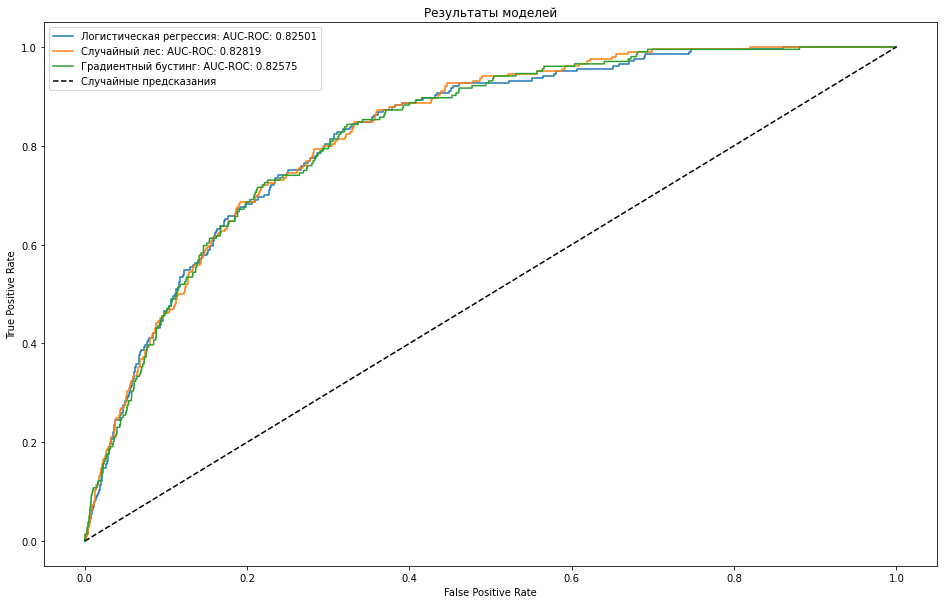

In [14]:
plt.figure(figsize=(16, 10))
plt.plot(fpr_lr, tpr_lr, label=f"Логистическая регрессия: AUC-ROC: {score_lr}")
plt.plot(
    fpr_rf,
    tpr_rf,
    label=
    f"Случайный лес: AUC-ROC: {np.round(roc_auc_score(te_data[TARGET_NAME],holdout_pred_rf),5)}"
)
plt.plot(
    fpr_gb,
    tpr_gb,
    label=
    f"Градиентный бустинг: AUC-ROC: {np.round(roc_auc_score(te_data[TARGET_NAME],holdout_pred_gb),5)}"
)
plt.plot([0, 1], [0, 1],
         label=f"Случайные предсказания",
         color='black',
         linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Результаты моделей')
plt.legend()
plt.show()